# Udacity Advance Lane Lines Project

In [32]:
# Place for adding all includes
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML

global imshow_enable 
imshow_enable = 1
%matplotlib inline

Total number of images: 20


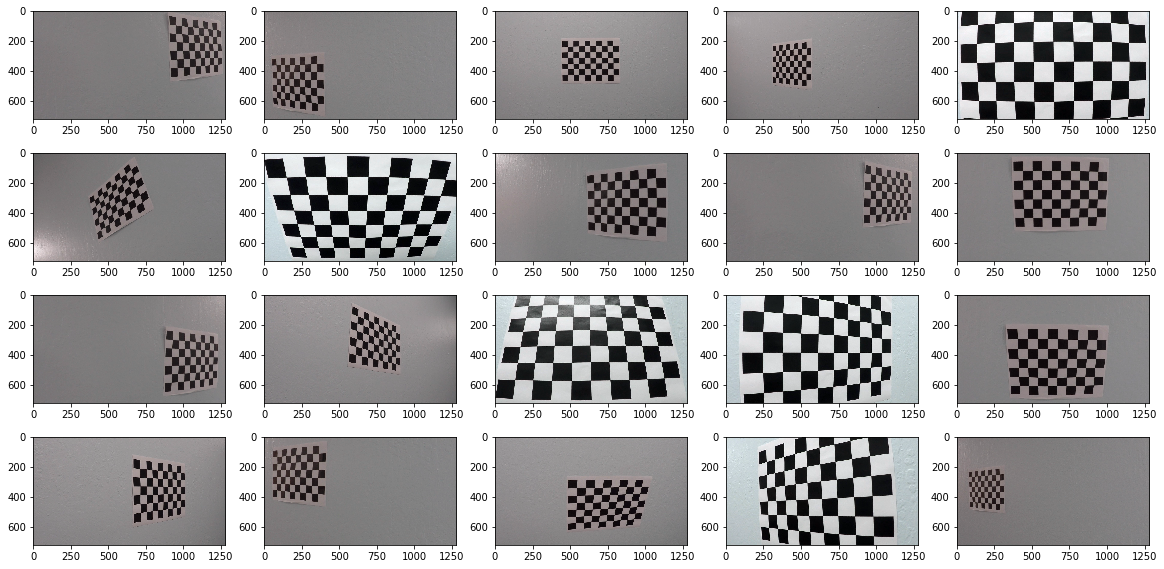

In [33]:
# Try to plot some images here

curr_dir = os.getcwd()

calib_dir = os.path.join(curr_dir, "camera_cal")

calib_images = os.listdir(calib_dir)
print ("Total number of images: %s" % (len(calib_images)))

if imshow_enable == 1:
    plt.figure(figsize=(20, 10))

    for i in range(0, len(calib_images)):
        each = calib_images[i]
        file_name = os.path.join(calib_dir, each)

        plt.subplot(4, 5, i + 1)
        image = cv2.imread(file_name)
        plt.imshow(image)
    plt.show()

### Project pipeline

Pipeline algorithm:

- Camera calibration
- Distortion correction
- Color/gradient threshold
- Perspective transform

### Camera Calibration

In [34]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)

# Code referred from https://github.com/udacity/CarND-Camera-Calibration

objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob("./camera_cal/calibration*.jpg")

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)


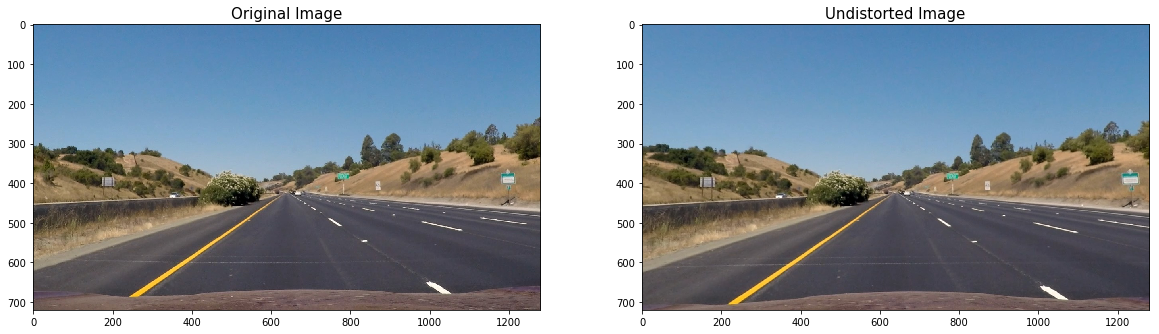

In [35]:
import pickle
%matplotlib inline

def plot_images(img1, img2, img1_title, img2_title):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img1)
    ax1.set_title(img1_title, fontsize=15)
    ax2.imshow(img2)
    ax2.set_title(img2_title, fontsize=15)


def undistort_image(img, objpoints, imgpoints):
    # Test undistortion on an image
    
    img_size = (img.shape[1], img.shape[0])
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None,None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

# file_name = "camera_cal/calibration4.jpg"
file_name = "test_images/straight_lines1.jpg"
image = cv2.imread(file_name)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
undistorted_img = undistort_image(image, objpoints, imgpoints)
if imshow_enable == 1:
    plot_images(image, undistorted_img, "Original Image", "Undistorted Image")


## Perspective transform


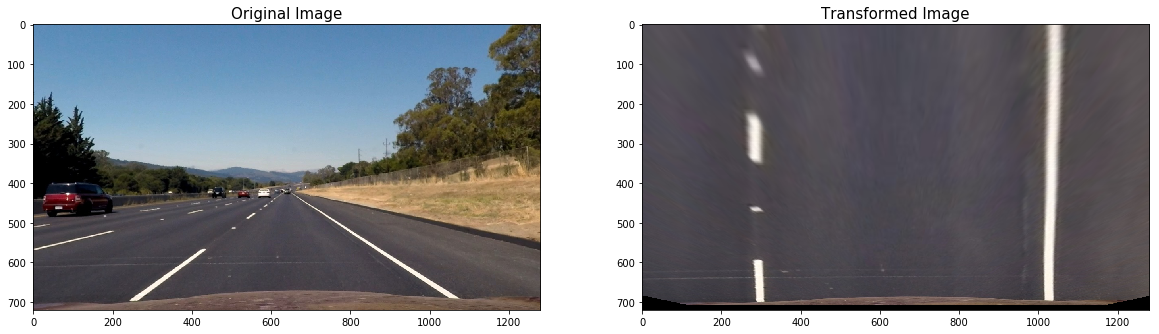

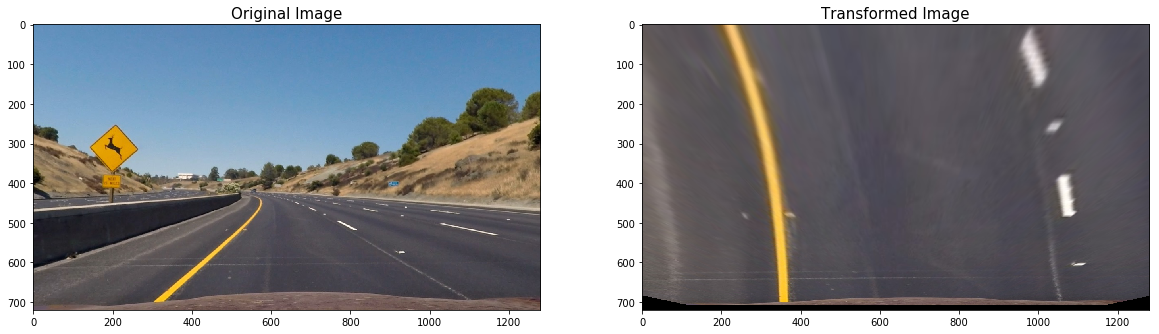

In [57]:
def get_src_dst_wrap_points(image):
    left_top = [585, 460]
    left_bottom = [255, 700]
    right_top = [700, 460]
    right_bottom = [1060, 700]
    src = np.array([ left_top, left_bottom, right_bottom, right_top], np.int32)
    src = src.reshape((-1,1,2))

    offset = 50
    left_edge = left_bottom[0] + offset
    right_edge = right_bottom[0] - offset
    
    left_top = [left_edge, 0]
    left_bottom = [left_edge, left_bottom[1]]
    right_top = [right_edge, 0]
    right_bottom = [right_edge, left_bottom[1]]

    dst = np.array([ left_top, left_bottom, right_bottom, right_top], np.int32)
    dst = dst.reshape((-1,1,2))
    return src, dst

def get_warp_perspective(image, src_pts, dst_pts, image_size):
    src_pts = np.float32(src_pts.tolist())
    dst_pts = np.float32(dst_pts.tolist())

    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    warped_image = cv2.warpPerspective(image, M, image_size, flags=cv2.INTER_LINEAR)
    Minv = cv2.getPerspectiveTransform(dst_pts, src_pts)
    return warped_image, M, Minv

def perspective_transform(img_src):
    img_dst = img_src.copy()
    
    src_pts, dst_pts = get_src_dst_wrap_points(img_src)
    
    warped, M, Minv = get_warp_perspective(img_src, src_pts, dst_pts, (img_src.shape[1], img_src.shape[0]))  
    return warped, M, Minv

def show_src_dst_image_warps(img):
    img_src = img.copy()
    img_dst = img_src.copy()

    src_pts, dst_pts = get_src_dst_wrap_points(img_src)

    src_img = cv2.polylines(img_src, [src_pts], True, (0,255,255), 10)
    dst_img = cv2.polylines(img_dst, [dst_pts], True, (200,124,255), 15)
    if imshow_enable == 1:
        plot_images(src_img, dst_img, "Original Image" , "Image with destination points")


file_list = ["./test_images/straight_lines2.jpg",
             "./test_images/test2.jpg"]

imshow_enable = 1

for file_name in file_list:    
    image = cv2.imread(file_name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = undistort_image(image, objpoints, imgpoints)

    warped_img, M, Minv = perspective_transform(image)
    if imshow_enable == 1:
        plot_images(image, warped_img, "Original Image", "Transformed Image")

## Binary Image

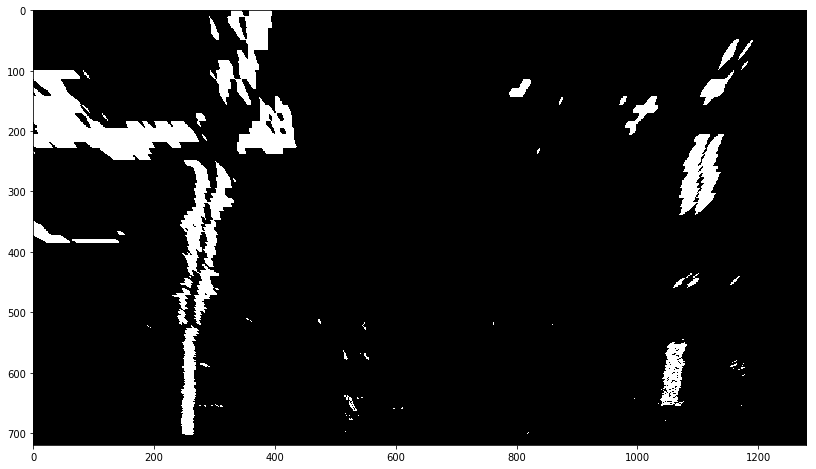

In [56]:
def get_binary_image(img):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype("float")
    s_channel = hls[:,:,2]

    # Grayscale image
    # NOTE: we already saw that standard grayscaling lost color information for the lane lines
    # Explore gradients in other colors spaces / color channels to see what might work better
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return color_binary, combined_binary

file_name = "test_images/test5.jpg"
image = cv2.imread(file_name)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
undistorted_img = undistort_image(image, objpoints, imgpoints) 
color_binary, combined_binary = get_binary_image(undistorted_img)

binary_warped, M, Minv = perspective_transform(combined_binary)

# Plotting thresholded images
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
# ax1.set_title('Stacked thresholds')
# ax1.imshow(color_binary)

# ax2.set_title('Combined S channel and gradient thresholds')
# ax2.imshow(combined_binary, cmap='gray')

# plot_images(combined_binary, binary_warped, "Combined Binary Image", "Transformed image")

plt.figure(figsize=(16,8))
plt.imshow(binary_warped, cmap='gray')

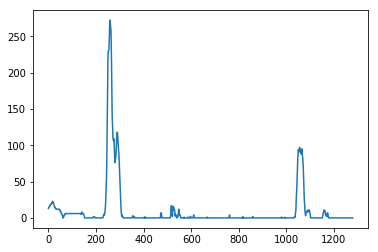

In [38]:
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)

In [39]:
def find_curvature(leftx, lefty, rightx, righty, ploty):
        # Define y-value where we want radius of curvature
        # I'll choose the maximum y-value, corresponding to the bottom of the image
        y_eval = np.max(ploty)
        # left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
        # right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
        # print(left_curverad, right_curverad)
        # Example values: 1926.74 1908.48

        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        
        # Now our radius of curvature is in meters
        # print(left_curverad, 'm', right_curverad, 'm')
        
        # Example values: 632.1 m    626.2 m
        return left_curverad, right_curverad

In [40]:
def find_lane_lines(binary_warped, debug):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    if (debug):
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        if (debug):
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2)
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    if (debug):
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.figure(figsize=(16,8))
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.axis("off");
    
    left_curv, right_curv = find_curvature(leftx, lefty, rightx, righty, ploty)
    
    return left_fitx, right_fitx, ploty, left_fit, right_fit, left_curv, right_curv

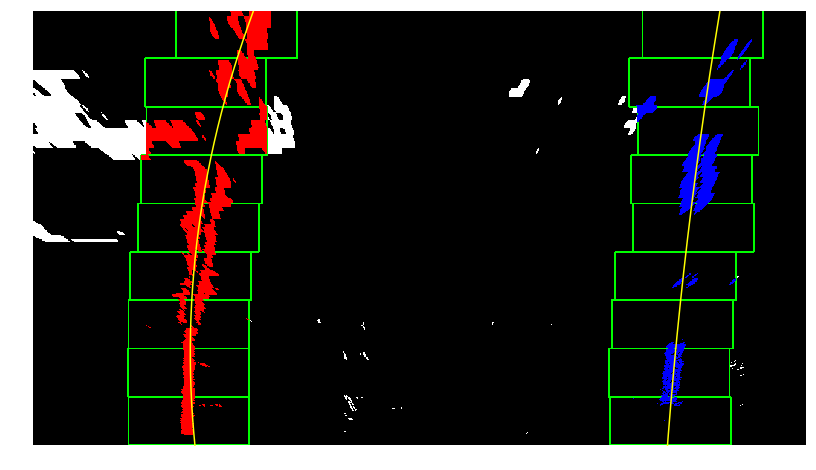

In [41]:
left_fitx, right_fitx, ploty, left_fit, right_fit, left_curv, right_curv = find_lane_lines( binary_warped, debug=True)

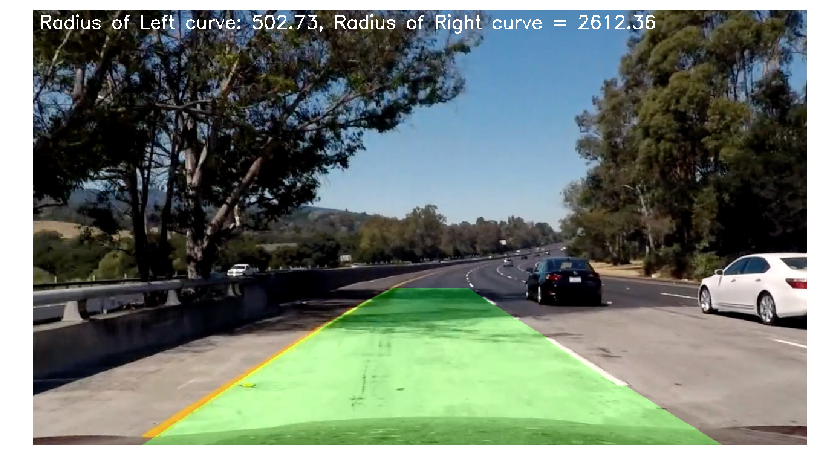

In [42]:
def  draw_images(binary_warped, left_fitx, right_fitx, ploty, undistorted, Minv, left_curv, right_curv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted.shape[1], undistorted.shape[0]))
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.3, 0)
    image_text = "Radius of Left curve: " + str(np.round(left_curv, 2)) + ", Radius of Right curve = " + str(np.round(right_curv, 2))
    cv2.putText(result, image_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    return result

result = draw_images(binary_warped, left_fitx, right_fitx, ploty, undistorted_img, Minv, left_curv, right_curv)
plt.figure(figsize=(16, 8))
plt.imshow(result)
plt.axis("off");

In [43]:
def process_frame(image):
    undistorted = undistort_image(image, objpoints, imgpoints)
    color_binary, combined_binary = get_binary_image(undistorted)
    binary_warped, M, Minv = perspective_transform(combined_binary)
    left_fitx, right_fitx, ploty, left_fit, right_fit, left_curv, right_curv = find_lane_lines(binary_warped, debug=False)
    result = draw_images(binary_warped, left_fitx, right_fitx, ploty, undistorted, Minv, left_curv, right_curv)
    return result

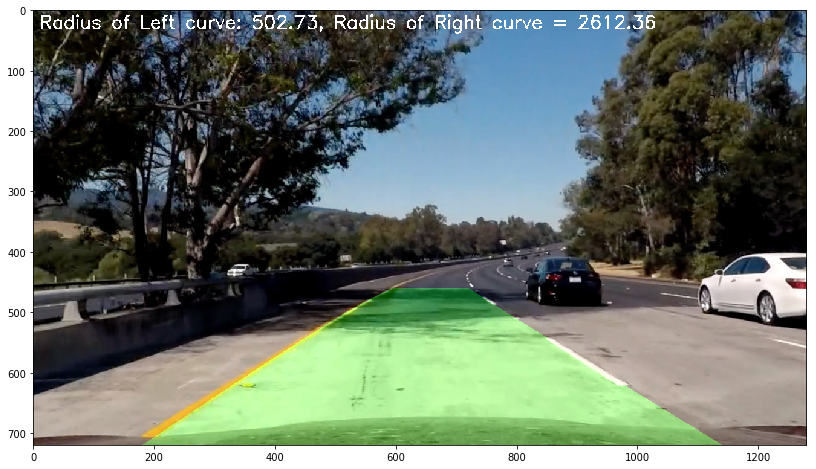

In [44]:
# Run on a test image

image = cv2.imread("test_images/test5.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

result = process_frame(image)

plt.figure(figsize=(16,8))
plt.imshow(result)

In [45]:
# Run the input video through the pipeline here
video_output = "output_images/project_video_output.mp4"
clip1 = VideoFileClip("project_video.mp4")
clip1_output = clip1.fl_image(process_frame)
%time clip1_output.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_images/project_video_output.mp4
[MoviePy] Writing video output_images/project_video_output.mp4


100%|█████████▉| 1260/1261 [12:54<00:00,  1.65it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_output.mp4 

CPU times: user 19min 22s, sys: 3.7 s, total: 19min 25s
Wall time: 12min 54s


In [46]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))